In [1]:
from __future__ import division

import pandas as pd
import numpy as np

from collections import Counter

from tqdm import tqdm
import progressbar

from sklearn.metrics import confusion_matrix, auc, accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(0)

In [3]:
train = pd.read_csv('spambase_old.csv')
test = pd.read_csv('spambase_new.csv')

In [4]:
X_train = train.drop(['label'], axis=1)
y_train = train['label'].as_matrix()

In [5]:
X_test = test.drop(['label'], axis=1)
y_test = test['label'].as_matrix()

In [6]:
def get_fpr_tpr(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    TP = cm[0][0]
    TN = cm[1][1]
    FP = cm[1][0]
    FN = cm[0][1]

    return 1.*FP/(FP + TN), 1.*TP/(TP+FN)


def predict_by_threshold(X, param, value):
    return np.array(X[param] >= value).astype(np.int)

def plot_roc(data, param):
    X = data.drop(['label'], axis=1)
    y_true = data['label'].as_matrix()
    value_set = set(X[param])
    value_set.add(max(value_set)+1)
    
    score = sorted([get_fpr_tpr(y_true, predict_by_threshold(X, param, v)) for v in value_set], key = lambda x: x[0])
    fpr = [s[0] for s in score]
    tpr = [s[1] for s in score]
    auc_score = auc(fpr, tpr)
    
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(fpr, tpr)   
    plt.plot([0, 1], [0, 1], ls= '--')
    plt.title('{}, auc score: {}'.format(param, auc_score))
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    
    return auc_score

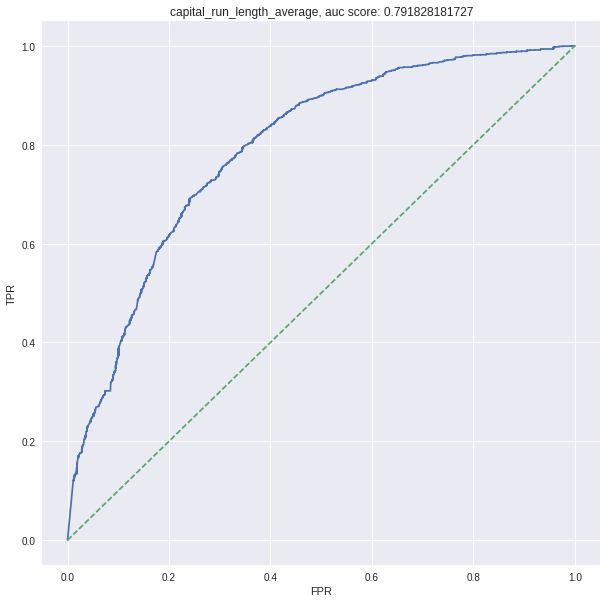

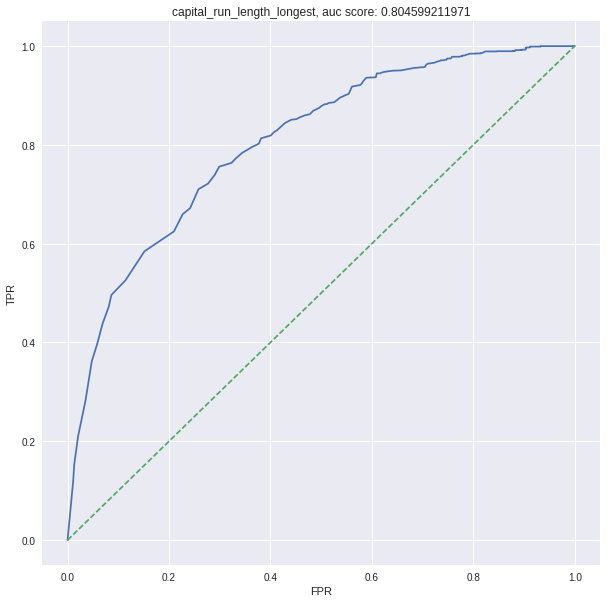

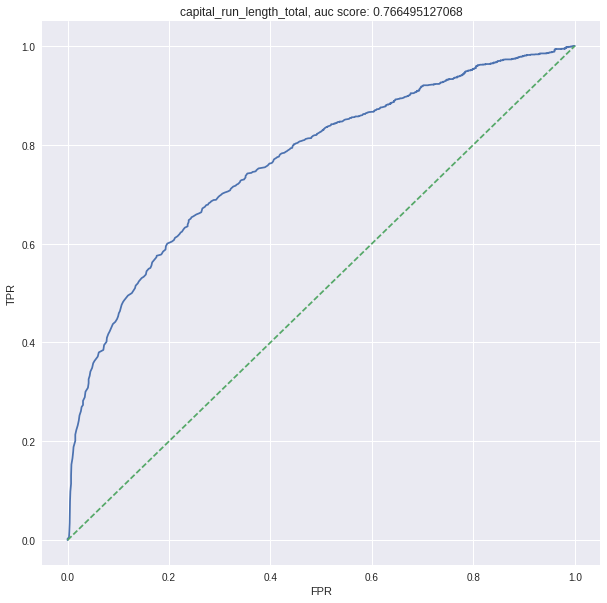

In [7]:
cols_roc = ['capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']
for c in cols_roc:
    plot_roc(train, c)

In [8]:
def find_best(data):
    X = data.drop(['label'], axis=1)
    y_true = data['label'].as_matrix()
    
    res = list()
    
    for param in X.columns.values:
        value_set = set(X[param])
        value_set.add(max(value_set)+1)

        score = sorted([get_fpr_tpr(y_true, predict_by_threshold(X, param, v)) for v in value_set], key = lambda x: x[0])
        fpr = [s[0] for s in score]
        tpr = [s[1] for s in score]
        auc_score = auc(fpr, tpr)

        res.append((param, auc_score))
        
    return sorted(res, key = lambda x: x[1])

In [9]:
params = find_best(train)
top_ten = params[-10:]

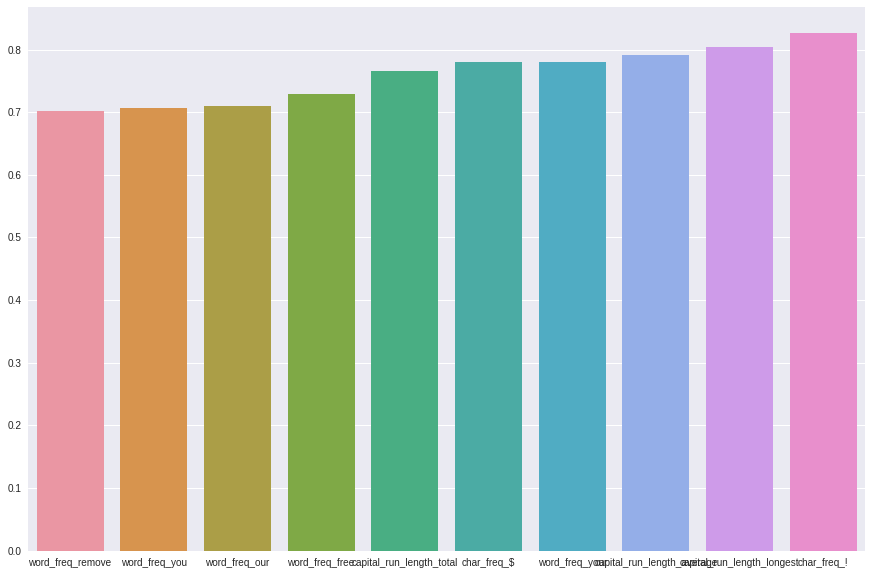

In [10]:
plt.figure(figsize=(15, 10))
sns.barplot(x=[p[0] for p in top_ten], y=[p[1] for p in top_ten])

In [11]:
def _gini_impurity(y):
    if len(y) == 0:
        return np.nan
    
    f_one = 1.*np.sum(y)/len(y)
    f_zero = 1. - f_one
    
    return 1 - (np.power(f_one, 2) + np.power(f_zero, 2))

def _gini_gain(y_l, y_r, info):
    l_imp = _gini_impurity(y_l)
    r_imp = _gini_impurity(y_r)
    
    return info - (len(y_l)/(len(y_l) + len(y_r))*l_imp + len(y_r)/(len(y_l) + len(y_r))*r_imp)


def _entropy_impurity(y):
    one_sum = np.sum(y)
    one_prob = one_sum / len(y)
    zero_prob = 1 - one_prob

    if one_prob == 1 or zero_prob == 1:
        return 0
    return -(zero_prob * (np.log(zero_prob)) + one_prob * (np.log(one_prob)))

def _entropy_gain(y_l, y_r, info):
    l_imp = _entropy_impurity(y_l)
    r_imp = _entropy_impurity(y_r)
    
    return info - (len(y_l)/(len(y_l) + len(y_r))*l_imp + len(y_r)/(len(y_l) + len(y_r))*r_imp)


info_gain_map = {'gini': _gini_gain,
                'entropy': _entropy_gain}

impurity_map = {'gini': _gini_impurity,
               'entropy': _entropy_impurity}

def calc_prob(y_pred):
    counts = Counter(y_pred)
    return counts[1]/(counts[0] + counts[1])

class TreeNode(object):
    def __init__(self, rule = None, feature = None, score = None, prob = None, is_leaf = False):
        self.is_leaf = is_leaf
        self.left = self.right = None
        self.feature = feature
        self.rule = rule
        self.score = score
        self.prob = prob

class DecisionTree(object):
    def __init__(self, depth, min_samples = 5, criterion = 'gini', max_features=-1, prob_threshold=0.5):
        self.max_depth = depth
        self.min_samples = min_samples
        self.root = None
        self.info_gain = info_gain_map[criterion]
        self.imputiry_func = impurity_map[criterion]
        self.max_features = max_features
#         self.predict_prob = predict_prob
        self.prob_threshold = prob_threshold
    
    def fit(self, X, y):
#         print X.shape, y.shape
        if self.max_features == -1:
            self.max_features = X.shape[1]
            
        self.features = np.random.choice(range(X.shape[1]), self.max_features, replace=False)
        if isinstance(X, pd.DataFrame):
            self.columns = X.columns.values[self.features]
        else:
            self.columns = np.array(['F{}'.format(i) for i in self.features])
            
        X = np.array(X)
        
        init_info = self.imputiry_func(y)
        self.root = self._build_tree(X, y, 0, init_info)
        
    def _build_tree(self, X, y, depth, info):
        if depth >= self.max_depth or X.shape[0] <= self.min_samples:
            return TreeNode(prob=calc_prob(y), is_leaf=True)
        
        best_rule = self._find_best_split(X, y, info)
        if best_rule is None:
            return TreeNode(prob=calc_prob(y), is_leaf=True)
        
        X_l, y_l, X_r, y_r = self._split(X, y, best_rule[0], best_rule[1])
        l_imp = self.imputiry_func(y_l)
        r_imp = self.imputiry_func(y_r)
        node = TreeNode(rule=best_rule[1], feature=best_rule[0], score=best_rule[2], is_leaf=False)
        node.left = self._build_tree(X_l, y_l, depth+1, l_imp)
        node.right = self._build_tree(X_r, y_r, depth+1, r_imp)
        
        return node    
    
    def _find_best_split(self, X, y, info):
        def calc_gain(X_l, y_l, X_r, y_r):
            return self.info_gain(y_l, y_r, info)
        
        total = list()
        for f in self.features:
            value_set = list(set(X[:, f]))
            res = [calc_gain(*self._split(X, y, f, v)) for v in value_set]
            
            best_idx, best_gain = max(enumerate(res), key = lambda x: x[1])
            total.append((f, value_set[best_idx], res[best_idx]))
        
        
        best_gain = 0.
        best_rule = None
        
        for t in total:
            if t[2] > best_gain:
                best_rule = t
                best_gain = t[2]
        
        return best_rule
            
    @staticmethod
    def _split(X, y, col, rule):       
        mask = X[:, col] > rule
        mask_l = np.logical_not(mask)
        
        X_r = X[mask]
        X_l = X[mask_l]
        y_r = y[mask]
        y_l = y[mask_l]

        return X_l, y_l, X_r, y_r
                
    def print_structure(self):
        self._structure(self.root, 0)
    
    def _structure(self, node, depth):
        if node is not None:
            print ' '*depth, '[', node.rule[0], '>', node.rule[1], ']\n'
            self._structure(node.left, depth+1)
            self._structure(node.right, depth+1)  
            
    def predict(self, X):
        X = np.array(X)
        return np.array([self.predict_one(v, False) for v in X])
    
    def predict_prob(self, X):
        X = np.array(X)
        return np.array([self.predict_one(v, True) for v in X])
    
    def predict_one(self, v, prob=False):
        leaf = self._walk_tree(self.root, v)
        if prob:
            return leaf.prob
        else:
            return int(leaf.prob >= self.prob_threshold)
    
    def _walk_tree(self, node, v):
        if node.is_leaf:
            return node
        
        if v[node.feature] > node.rule:
            return self._walk_tree(node.right, v)
        else:
            return self._walk_tree(node.left, v)

In [12]:
def plot_tree(X_train, y_train, X_test, y_test, depth_range, criterion):
    res = list()
    for d in depth_range:
        tr = DecisionTree(d, criterion=criterion)
        tr.fit(X_train, y_train)
        y_pred = tr.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print 'depth: {}, accuracy: {}'.format(d, acc)
        res.append((d, acc))
    
    plt.figure(figsize=(10, 7))
    plt.plot([r[0] for r in res], [r[1] for r in res])
    plt.title(criterion)

depth: 2, accuracy: 0.85342019544
depth: 3, accuracy: 0.890336590662
depth: 4, accuracy: 0.900108577633
depth: 5, accuracy: 0.909880564604
depth: 6, accuracy: 0.907709011944
depth: 7, accuracy: 0.913137893594
depth: 8, accuracy: 0.922909880565
depth: 9, accuracy: 0.926167209555
depth: 10, accuracy: 0.925081433225


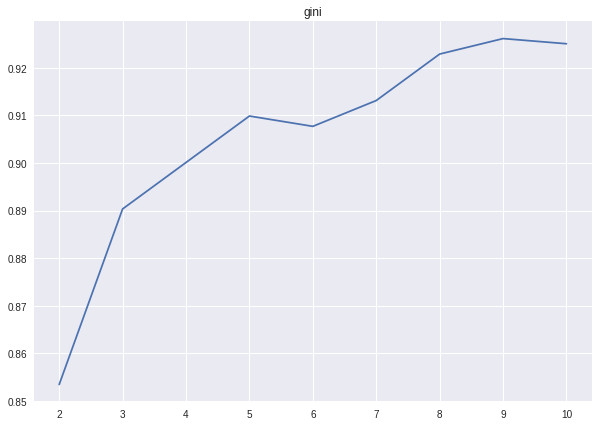

In [708]:
plot_tree(X_train, y_train, X_test, y_test, range(2, 11), criterion='gini')

/home/vladka/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in long_scalars


depth: 2, accuracy: 0.85342019544
depth: 3, accuracy: 0.865363735071
depth: 4, accuracy: 0.907709011944
depth: 5, accuracy: 0.915309446254
depth: 6, accuracy: 0.914223669924
depth: 7, accuracy: 0.922909880565
depth: 8, accuracy: 0.922909880565
depth: 9, accuracy: 0.923995656895
depth: 10, accuracy: 0.925081433225


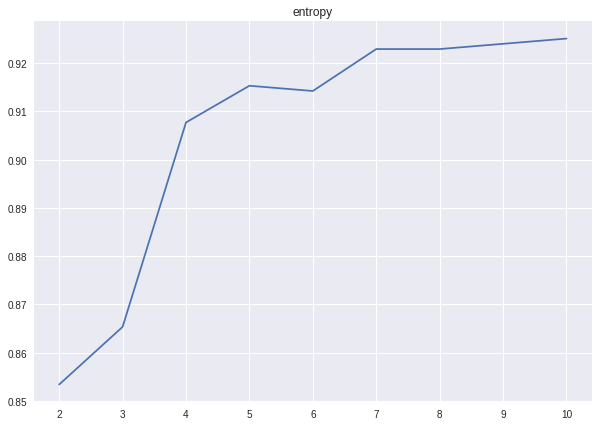

In [709]:
plot_tree(X_train, y_train, X_test, y_test, range(2, 11), criterion='entropy')

In [13]:
top_ten_names = [t[0] for t in top_ten]
X_train_top = X_train[top_ten_names]
X_test_top = X_test[top_ten_names]

depth: 2, accuracy: 0.832790445168
depth: 3, accuracy: 0.877307274701
depth: 4, accuracy: 0.893593919653
depth: 5, accuracy: 0.889250814332
depth: 6, accuracy: 0.892508143322
depth: 7, accuracy: 0.884907709012
depth: 8, accuracy: 0.884907709012
depth: 9, accuracy: 0.896851248643
depth: 10, accuracy: 0.891422366992


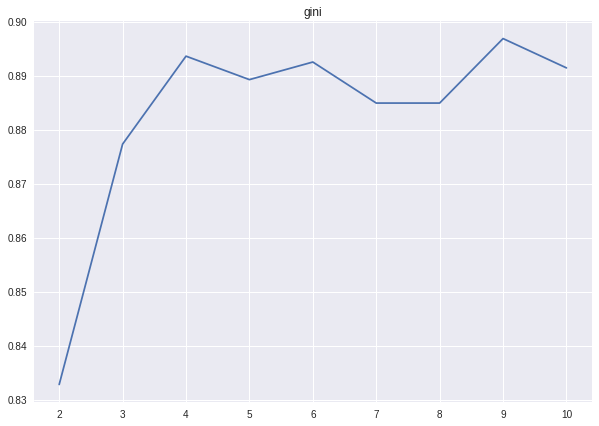

In [752]:
plot_tree(X_train_top, y_train, X_test_top, y_test, range(2, 11), criterion='gini')

/home/vladka/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in long_scalars


depth: 2, accuracy: 0.832790445168
depth: 3, accuracy: 0.85233441911
depth: 4, accuracy: 0.894679695983
depth: 5, accuracy: 0.893593919653
depth: 6, accuracy: 0.893593919653
depth: 7, accuracy: 0.899022801303
depth: 8, accuracy: 0.905537459283
depth: 9, accuracy: 0.896851248643
depth: 10, accuracy: 0.897937024973


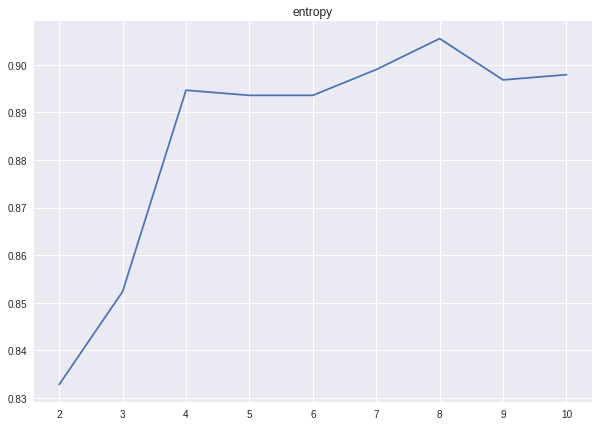

In [15]:
plot_tree(X_train_top, y_train, X_test_top, y_test, range(2, 11), criterion='entropy')

In [771]:
class RandomForest(object):
    def __init__(self, n_estimators=10, max_features=10, max_depth=5, criterion='gini', selection='vote', percent=0.25):
        self.n_estimators=10
        self.max_features=max_features
        self.max_depth=5
        self.criterion=criterion
        self.selection=selection
        self.percent = percent
    
    def fit(self, X, y):
        X = np.array(X)
        self.estimators = [DecisionTree(depth=self.max_depth, criterion=self.criterion, max_features=self.max_features) for _ in range(self.n_estimators)]
        for tr in self.estimators:
            X_bag, y_bag = self._bagging(X, y)
            tr.fit(X_bag, y_bag)
    
    def predict(self, X):
        if self.selection == 'vote':
            res = np.zeros(X.shape[0], dtype=float)
            for idx, tr in enumerate(self.estimators):
                res += tr.predict(X)
            res /= len(self.estimators)
            
            return np.array(res >= 0.5).astype(int)
        elif self.selection == 'prob_sum':
            res = np.zeros(X.shape[0], dtype=float)
            for idx, tr in enumerate(self.estimators):
                res += tr.predict_prob(X)
            res /= len(self.estimators)
            
            return np.array(res >= 0.5).astype(int)
    
    def _bagging(self, X, y):
        X_tmp = X.copy()
        y_tmp = y.copy()
        idx = np.random.choice(X_tmp.shape[0], int(X.shape[0]*self.percent))
        X_tmp = X_tmp[idx]
        y_tmp = y_tmp[idx]
        
        return X_tmp, y_tmp

In [774]:
def find_best_forest(X_train, y_train, X_test, y_test, selection, depth_range, estim_range, feat_range):
    res = list()
    pbar = progressbar.ProgressBar(maxval=len(depth_range)*len(estim_range)*len(feat_range),
                                  widgets=[
                                            progressbar.Percentage(),
                                            ' [', progressbar.Counter(), '] ',
                                            progressbar.Bar(),
                                        ])
    pbar.start()
    for d in depth_range:
        for e in estim_range:
            for f in feat_range:
                tr = RandomForest(max_depth=d, max_features=f, n_estimators=e, selection=selection)
                tr.fit(X_train, y_train)
                y_pred = tr.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                res.append((d, e, f, acc))
                pbar.update(pbar.currval + 1)
    
    return max(res, key = lambda x : x[3])

In [735]:
best_f = find_best_forest(X_train, y_train, X_test, y_test, 'vote',
                          depth_range=range(10,61, 10), 
                          estim_range=[10,15,20,25,30], 
                          feat_range=range(10, 56, 5))
print best_f

(10, 15, 35, ('char_freq_!', 0.82622063274579483), 0.94462540716612375)


In [777]:
best_f = find_best_forest(X_train, y_train, X_test, y_test, 'prob_sum',
                          depth_range=range(10,61, 10), 
                          estim_range=[10,15,20,25,30], 
                          feat_range=range(10, 56, 5))
print best_f

(20, 25, 40, ('char_freq_!', 0.82622063274579483), 0.94136807817589574)


In [783]:
def plot_roc_prob(X_train, y_train, X_test, y_test, p_range):
    res = list()
    pbar = progressbar.ProgressBar()
    for p in pbar(p_range):
        tr = DecisionTree(depth=10, prob_threshold=p)
        tr.fit(X_train, y_train)
        res.append(get_fpr_tpr(y_test, tr.predict(X_test)))
    
    res = sorted(res, key = lambda x: x[0])
    fpr = [s[0] for s in res]
    tpr = [s[1] for s in res]
    auc_score = auc(fpr, tpr)
    
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(fpr, tpr, marker='o')   
    plt.plot([0, 1], [0, 1], ls= '--')
    plt.title('leaf probability, auc score: {}'.format(auc_score))
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    return res

100% |########################################################################|


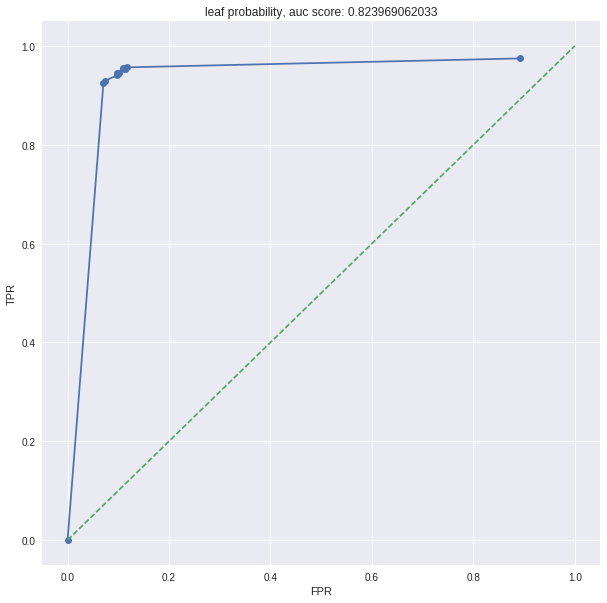

In [784]:
scores = plot_roc_prob(X_train, y_train, X_test, y_test, np.arange(0., 1.05, 0.1))